In [88]:
import os
import os.path as op
import collections
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.io
from functools import partial
import numpy as np
from scipy.ndimage import gaussian_filter1d
import json
from mne.stats import permutation_cluster_test, permutation_cluster_1samp_test, ttest_1samp_no_p

In [89]:
ages = ['three', 'six', 'twelve']


def load_bursts(age):
    file_path = f'merged_bursts_{age}.json'
    with open(file_path, 'r') as f:
        try:
            burst_data = json.load(f)
        except json.JSONDecodeError as e:
            raise ValueError(f"Error decoding JSON from file {file_path}: {e}")
        
        # Create a dictionary of lists
        bursts_dict = collections.defaultdict(list)
        for b in burst_data:
            for key, val in b.items():
                bursts_dict[key].append(val)

        #Convert all lists to numpy arrays
        for key in bursts_dict:
            bursts_dict[key] = np.array(bursts_dict[key])

    return bursts_dict

def flatten_bursts(bursts):
    #flattens the nested structure of bursts
    flattened = {
        'subject': [],
        'epoch': [],
        'session': [],
        'channel': [],
        'system': [],
        'cluster': [],
        'trial': [],
        'peak_time': [],
        'peak_freq': [],
        'peak_amp_iter': [],
        'peak_amp_base': [],
        'waveform': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'polarity': [],
        'peak_adjustment': []
    }
    
    for i in range(len(bursts['subject'])):
        burst_dict = bursts['bursts'][i]
        n_bursts = len(burst_dict['trial'])
        
        for j in range(n_bursts):
            flattened['subject'].append(bursts['subject'][i])
            flattened['epoch'].append(bursts['epoch'][i])
            flattened['session'].append(bursts['session'][i])
            flattened['channel'].append(bursts['channel'][i])
            flattened['system'].append(bursts['system'][i])
            flattened['cluster'].append(bursts['cluster'][i])
            flattened['trial'].append(burst_dict['trial'][j])
            
            for key in ['peak_time', 'peak_freq', 'peak_amp_iter', 'peak_amp_base',
                       'fwhm_freq', 'fwhm_time', 'polarity', 'peak_adjustment']:
                if key in burst_dict and j < len(burst_dict[key]):
                    flattened[key].append(burst_dict[key][j])
                else:
                    flattened[key].append(np.nan)
            
            if 'waveform' in burst_dict and j < len(burst_dict['waveform']):
                flattened['waveform'].append(burst_dict['waveform'][j])
            else:
                flattened['waveform'].append([])
    
    for key in flattened:
        if key != 'waveform':
            flattened[key] = np.array(flattened[key])
    
    return flattened

In [90]:
ages = ['three', 'six', 'twelve']

dfs = []
#def load_pc_scores(age):
for age in ages:
    file_path = f"/home/ldurieux/devmobeta_grasp/bursts_with_pc_{age}.csv"
    print(f"Lecture du fichier : {file_path}")

    df = pd.read_csv(file_path)

    df['time'] = df['time'].astype(float) #time must be a float for histograms
    #df['PC2'] = df['PC2'].astype(float)

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print(df_all.head())
print(df_all.shape)


Lecture du fichier : /home/ldurieux/devmobeta_grasp/bursts_with_pc_three.csv
Lecture du fichier : /home/ldurieux/devmobeta_grasp/bursts_with_pc_six.csv
Lecture du fichier : /home/ldurieux/devmobeta_grasp/bursts_with_pc_twelve.csv
   subject    age epoch       system  trial   time cluster       PC1  \
0  sub-253  three    go  BrainVision      1 -2.298      C3 -1.641337   
1  sub-253  three    go  BrainVision      1 -2.688      C3  1.531324   
2  sub-253  three    go  BrainVision      2  0.778      C3 -4.089901   
3  sub-253  three    go  BrainVision      2 -1.050      C3  3.224046   
4  sub-253  three    go  BrainVision      3  2.334      C3  4.835654   

        PC2       PC3  ...      PC11      PC12      PC13      PC14      PC15  \
0  0.871260  5.294381  ... -0.727577  0.647452 -1.601184  0.619694 -0.819925   
1 -5.184664  1.898314  ... -2.187958  0.146829  0.937790  0.904363  0.747342   
2 -2.226000 -2.958757  ...  0.908986  0.339883  0.842018  1.536414 -1.143805   
3  2.149779  4.06

In [93]:
def compute_rate(bursts, bin_dt, smth_kern, baseline_window=[-4.5, -1]):
    
    epochs = ['go', 'grsp']
    epoch_time_limits = {'go': [-4.5, 4.5], 'grsp': [-4.5, 4.5]}

    c_rates = {epoch: [] for epoch in epochs}
    epoch_bins = {epoch: np.arange(epoch_time_limits[epoch][0], epoch_time_limits[epoch][1], bin_dt)
                  for epoch in epochs}
    epoch_time = {}
    group_means = {}

    subjects = np.unique(bursts['subject'])

    for subject in subjects:
        subj_rows = (bursts['subject'] == subject)
        subj_c_rates = {}

        # baseline calculation on 'go' only
        bins_go = epoch_bins['go']
        epoch_rows_go = subj_rows & (bursts['epoch'] == 'go')
        trials_go = np.unique(bursts['trial'][epoch_rows_go])
        trial_rates_go = []

        for trial in trials_go:
            trial_rows = epoch_rows_go & (bursts['trial'] == trial)
            hist, _ = np.histogram(bursts['peak_time'][trial_rows], bins=bins_go)
            trial_rate = hist.astype(float) / bin_dt
            trial_rates_go.append(trial_rate)

        if len(trial_rates_go) > 0:
            mean_rate_go = np.nanmean(trial_rates_go, axis=0)  # Mean trials
            baseline_mask = (bins_go[:-1] >= baseline_window[0]) & (bins_go[:-1] <= baseline_window[1]) 
            baseline = np.nanmean(mean_rate_go[baseline_mask])  # Baseline on mean 

        else:
            continue
            #baseline = 0
            
        #burst rate on eache epoch
        for epoch_type in epochs:
                
            bins = epoch_bins[epoch_type]
            epoch_rows = subj_rows & (bursts['epoch'] == epoch_type)
            trials = np.unique(bursts['trial'][epoch_rows])
            trial_rates = []

            for trial in trials:
                trial_rows = epoch_rows & (bursts['trial'] == trial)
                hist, _ = np.histogram(bursts['peak_time'][trial_rows], bins=bins)
                trial_rate = hist.astype(float) / bin_dt
                trial_rates.append(trial_rate)

            if len(trial_rates) == 0:
                continue

            trial_rates = np.array(trial_rates)
            epoch_burst_rate = np.nanmean(trial_rates, axis=0)
            epoch_burst_rate = gaussian_filter1d(epoch_burst_rate, smth_kern)

            # baseline subtraction from 'go'
            epoch_burst_rate = epoch_burst_rate - baseline
            
            subj_c_rates[epoch_type] = epoch_burst_rate
        
        for epoch_type in epochs:
            if epoch_type in subj_c_rates:
                epoch_time[epoch_type] = bins[:-1]
                c_rates[epoch_type].append(subj_c_rates[epoch_type])

    # conversion to array and inter-subject average
    for epoch_type in epochs:
        if len(c_rates[epoch_type]) > 0:
            c_rates[epoch_type] = np.array(c_rates[epoch_type])
            group_means[epoch_type] = np.nanmean(c_rates[epoch_type], axis=0)
        else:
            c_rates[epoch_type] = None
            group_means[epoch_type] = None

    return epoch_time, c_rates, group_means


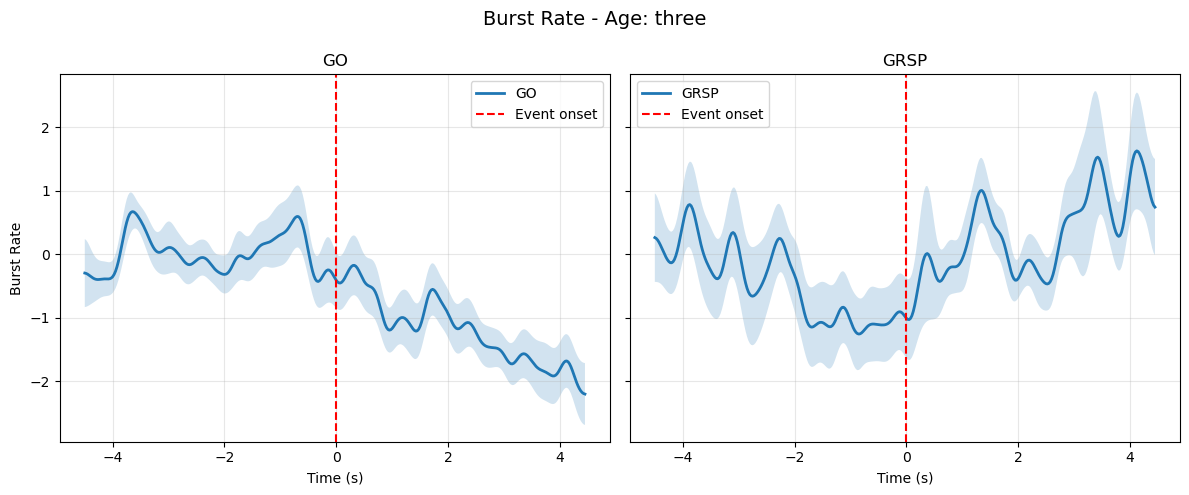

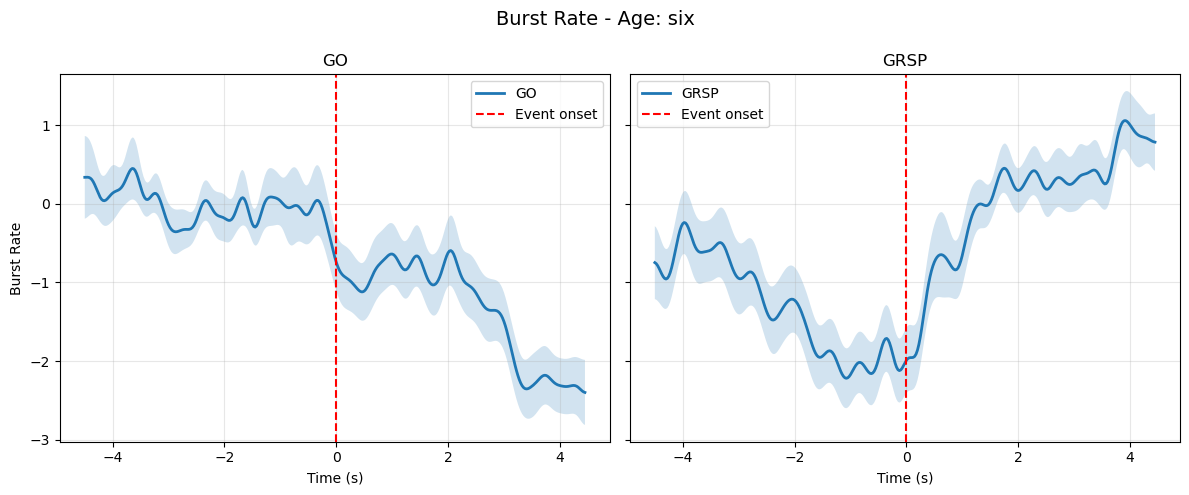

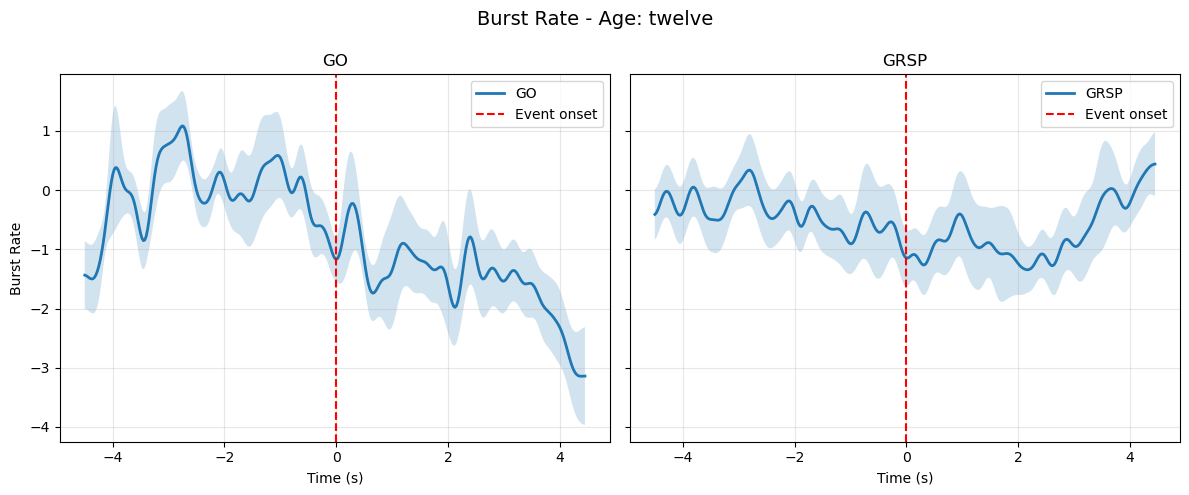

In [94]:
ages = ['three', 'six', 'twelve']
epoch_types = ['go', 'grsp']

for age in ages:
    bursts = load_bursts(age)
    bursts = flatten_bursts(bursts)
    epoch_time, c_rates, group_means = compute_rate(bursts, bin_dt=0.025, smth_kern=5)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for i, epoch_type in enumerate(epoch_types):
        ax = axes[i]
        
        mean_rate = group_means[epoch_type]

        if c_rates[epoch_type] is not None and len(c_rates[epoch_type]) > 1:
            sem_rate = np.std(c_rates[epoch_type], axis=0) / np.sqrt(c_rates[epoch_type].shape[0])
            ax.fill_between(epoch_time[epoch_type],
                            mean_rate - sem_rate,
                            mean_rate + sem_rate,
                            alpha=0.2)

        ax.plot(epoch_time[epoch_type], mean_rate, label=f'{epoch_type.upper()}', linewidth=2)
        ax.axvline(0, color='red', linestyle='--', label='Event onset')
        ax.set_title(epoch_type.upper())
        ax.set_xlabel('Time (s)')
        if i == 0:
            ax.set_ylabel('Burst Rate')
        ax.grid(True, alpha=0.3)
        ax.legend()

    fig.suptitle(f'Burst Rate - Age: {age}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    #plt.savefig(f'burst_rate_{age}.png', dpi=300)
    plt.show()


In [95]:
ages = ['three', 'six', 'twelve']
epoch_types = ['go', 'grsp']

for age in ages:
    bursts = load_bursts(age)
    bursts = flatten_bursts(bursts)
    epoch_time, c_rates, group_means = compute_rate(bursts, bin_dt=0.025, smth_kern=5)
    print(f"Age: {age} - Nombre de sujets: {c_rates['go'].shape[0]}")

Age: three - Nombre de sujets: 45
Age: six - Nombre de sujets: 43
Age: twelve - Nombre de sujets: 20


In [84]:
def ttest_1samp_no_p(X):
    t_values = np.mean(X, axis=0) / (np.std(X, axis=0, ddof=1) / np.sqrt(X.shape[0]))
    return t_values

In [85]:
def compute_significance_clusters(rates_data, n_comps=6, n_quartiles=4, 
                                  alpha=0.05, n_permutations=1000):
    
    if rates_data.shape[0] < 2:
        return np.zeros(rates_data.shape[1], dtype=bool), [], []
    
    alpha_corrected = alpha
    
    # TFCE parameters
    threshold_tfce = dict(start=0, step=0.01)
    sigma = 1e-3 #Avoid division by zero if variance = 0
    hat_corr = partial(ttest_1samp_no_p, sigma = sigma)
    
    try:
        T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
            rates_data, # sujet x time
            stat_fun=ttest_1samp_no_p, 
            threshold=threshold_tfce, # TFCE method
            n_permutations=n_permutations, 
            n_jobs=-1, 
            out_type="mask", 
            verbose=False, 
            adjacency=None, 
            buffer_size=None 
        )
        
        significant_mask = np.zeros(rates_data.shape[1], dtype=bool)
        
        if len(clusters) > 0:
            for i, cluster in enumerate(clusters):
                if cluster_p_values[i] < alpha_corrected:
                    significant_mask[cluster[0]] = True
            
        return significant_mask, clusters, cluster_p_values
        
    except Exception as e:
        return np.zeros(rates_data.shape[1], dtype=bool), [], []

In [86]:
def compute_quartile_burst_rates(df, pc_name, age, epoch,
                                 bin_dt=0.05, time_win=[-4.5, 4.5],
                                 baseline_window=[-4.5, -1],
                                 smooth_sigma=5,
                                 exclude_outliers=True,
                                 outlier_threshold=2.0):

    #  Selection of age & epoch 
    df_ep = df[(df["age"] == age) & (df["epoch"] == epoch)].copy()
    if df_ep.empty:
        return None, None, None

    #  Quartiles 
    df_ep["quartile"] = pd.qcut(df_ep[pc_name], 4,
                                labels=[1, 2, 3, 4], duplicates="drop")

    #  Bins temporels 
    bins = np.arange(time_win[0], time_win[1] + bin_dt, bin_dt)
    bin_centers = bins[:-1] + bin_dt/2

    #  Stockage 
    rates_quartiles = {f"Q{q}": [] for q in [1, 2, 3, 4]}
    excluded = {f"Q{q}": {"excluded": [], "total": 0} for q in [1, 2, 3, 4]}

    for q in [1, 2, 3, 4]:

        df_q = df_ep[df_ep["quartile"] == q]
        subjects = df_q["subject"].unique()

        subj_rates, subj_ids, subj_means = [], [], []

        df_go = df[(df["age"] == age) & (df["epoch"] == "go")].copy()
        df_go["quartile"] = pd.qcut(df_go[pc_name], 4,
                                    labels=[1, 2, 3, 4], duplicates="drop")

        df_go_q = df_go[df_go["quartile"] == q]

        go_trial_rates = []

        for subj in df_go_q["subject"].unique():
            df_s = df_go_q[df_go_q["subject"] == subj]

            subj_trials = []
            for tr in df_s["trial"].unique():
                df_t = df_s[df_s["trial"] == tr]
                hist, _ = np.histogram(df_t["time"], bins=bins)
                rate = gaussian_filter1d(hist / bin_dt, sigma=smooth_sigma)
                subj_trials.append(rate)

            if subj_trials:
                go_trial_rates.append(np.mean(subj_trials, axis=0))

        # baseline quartile q × age
        if go_trial_rates:
            go_rates = np.array(go_trial_rates)
            mask_baseline = (bin_centers >= baseline_window[0]) & (bin_centers <= baseline_window[1])
            baseline_value = np.mean(go_rates[:, mask_baseline])
        else:
            baseline_value = 0


        #  rates for this quartile
        for subj in subjects:
            df_subj = df_q[df_q["subject"] == subj]
            trials = df_subj["trial"].unique()

            trial_rates = []
            for tr in trials:
                df_tr = df_subj[df_subj["trial"] == tr]
                hist, _ = np.histogram(df_tr["time"], bins=bins)
                rate = gaussian_filter1d(hist / bin_dt, sigma=smooth_sigma)
                trial_rates.append(rate)

            if trial_rates:
                rate = np.mean(trial_rates, axis=0)
                subj_rates.append(rate)
                subj_ids.append(subj)
                subj_means.append(np.mean(rate))

        subj_rates = np.array(subj_rates)
        subj_means = np.array(subj_means)
        excluded[f"Q{q}"]["total"] = len(subj_rates)

        #  Outliers 
        if exclude_outliers and len(subj_rates) > 2:
            m, sd = np.mean(subj_means), np.std(subj_means)
            keep = np.abs(subj_means - m) < outlier_threshold * sd
            excluded[f"Q{q}"]["excluded"] = list(np.array(subj_ids)[~keep])
            subj_rates = subj_rates[keep]

        # substraction go baseline
        subj_rates = subj_rates - baseline_value

        rates_quartiles[f"Q{q}"] = subj_rates

    return bin_centers, rates_quartiles, excluded

 PC4

three - go:
 [0.72, 4.47]s, center 2.62s
 [2.47, 4.27]s, center 3.37s

three - grsp:
 [-4.18, 1.07]s, center -1.53s
 [1.52, 2.77]s, center 2.17s
 [-3.93, -3.53]s, center -3.73s
 [-1.78, -0.48]s, center -1.13s
 [2.12, 2.47]s, center 2.32s
 [-2.13, -0.18]s, center -1.13s
 [0.77, 1.02]s, center 0.92s
 [-2.88, -2.68]s, center -2.78s
 [-1.93, 1.07]s, center -0.43s
 [1.87, 2.77]s, center 2.32s

six - go:
 [0.22, 4.47]s, center 2.37s
 [3.12, 4.47]s, center 3.82s
 [4.32, 4.47]s, center 4.42s
 [-0.33, 0.67]s, center 0.17s
 [1.17, 1.32]s, center 1.27s
 [2.37, 4.47]s, center 3.42s

six - grsp:
 [-4.47, 0.52]s, center -1.98s
 [-0.73, -0.53]s, center -0.63s
 [-1.13, 0.27]s, center -0.43s
 [-2.68, 0.97]s, center -0.83s

twelve - go:
 [2.87, 3.22]s, center 3.07s
 [-4.47, -3.88]s, center -4.18s
 [-2.33, -1.78]s, center -2.03s
 [-0.73, 2.27]s, center 0.77s
 [2.62, 3.02]s, center 2.82s
 [3.37, 4.47]s, center 3.92s
 [0.42, 1.22]s, center 0.82s
 [1.77, 2.77]s, center 2.27s

twelve - grsp:
 [0.02, 0.

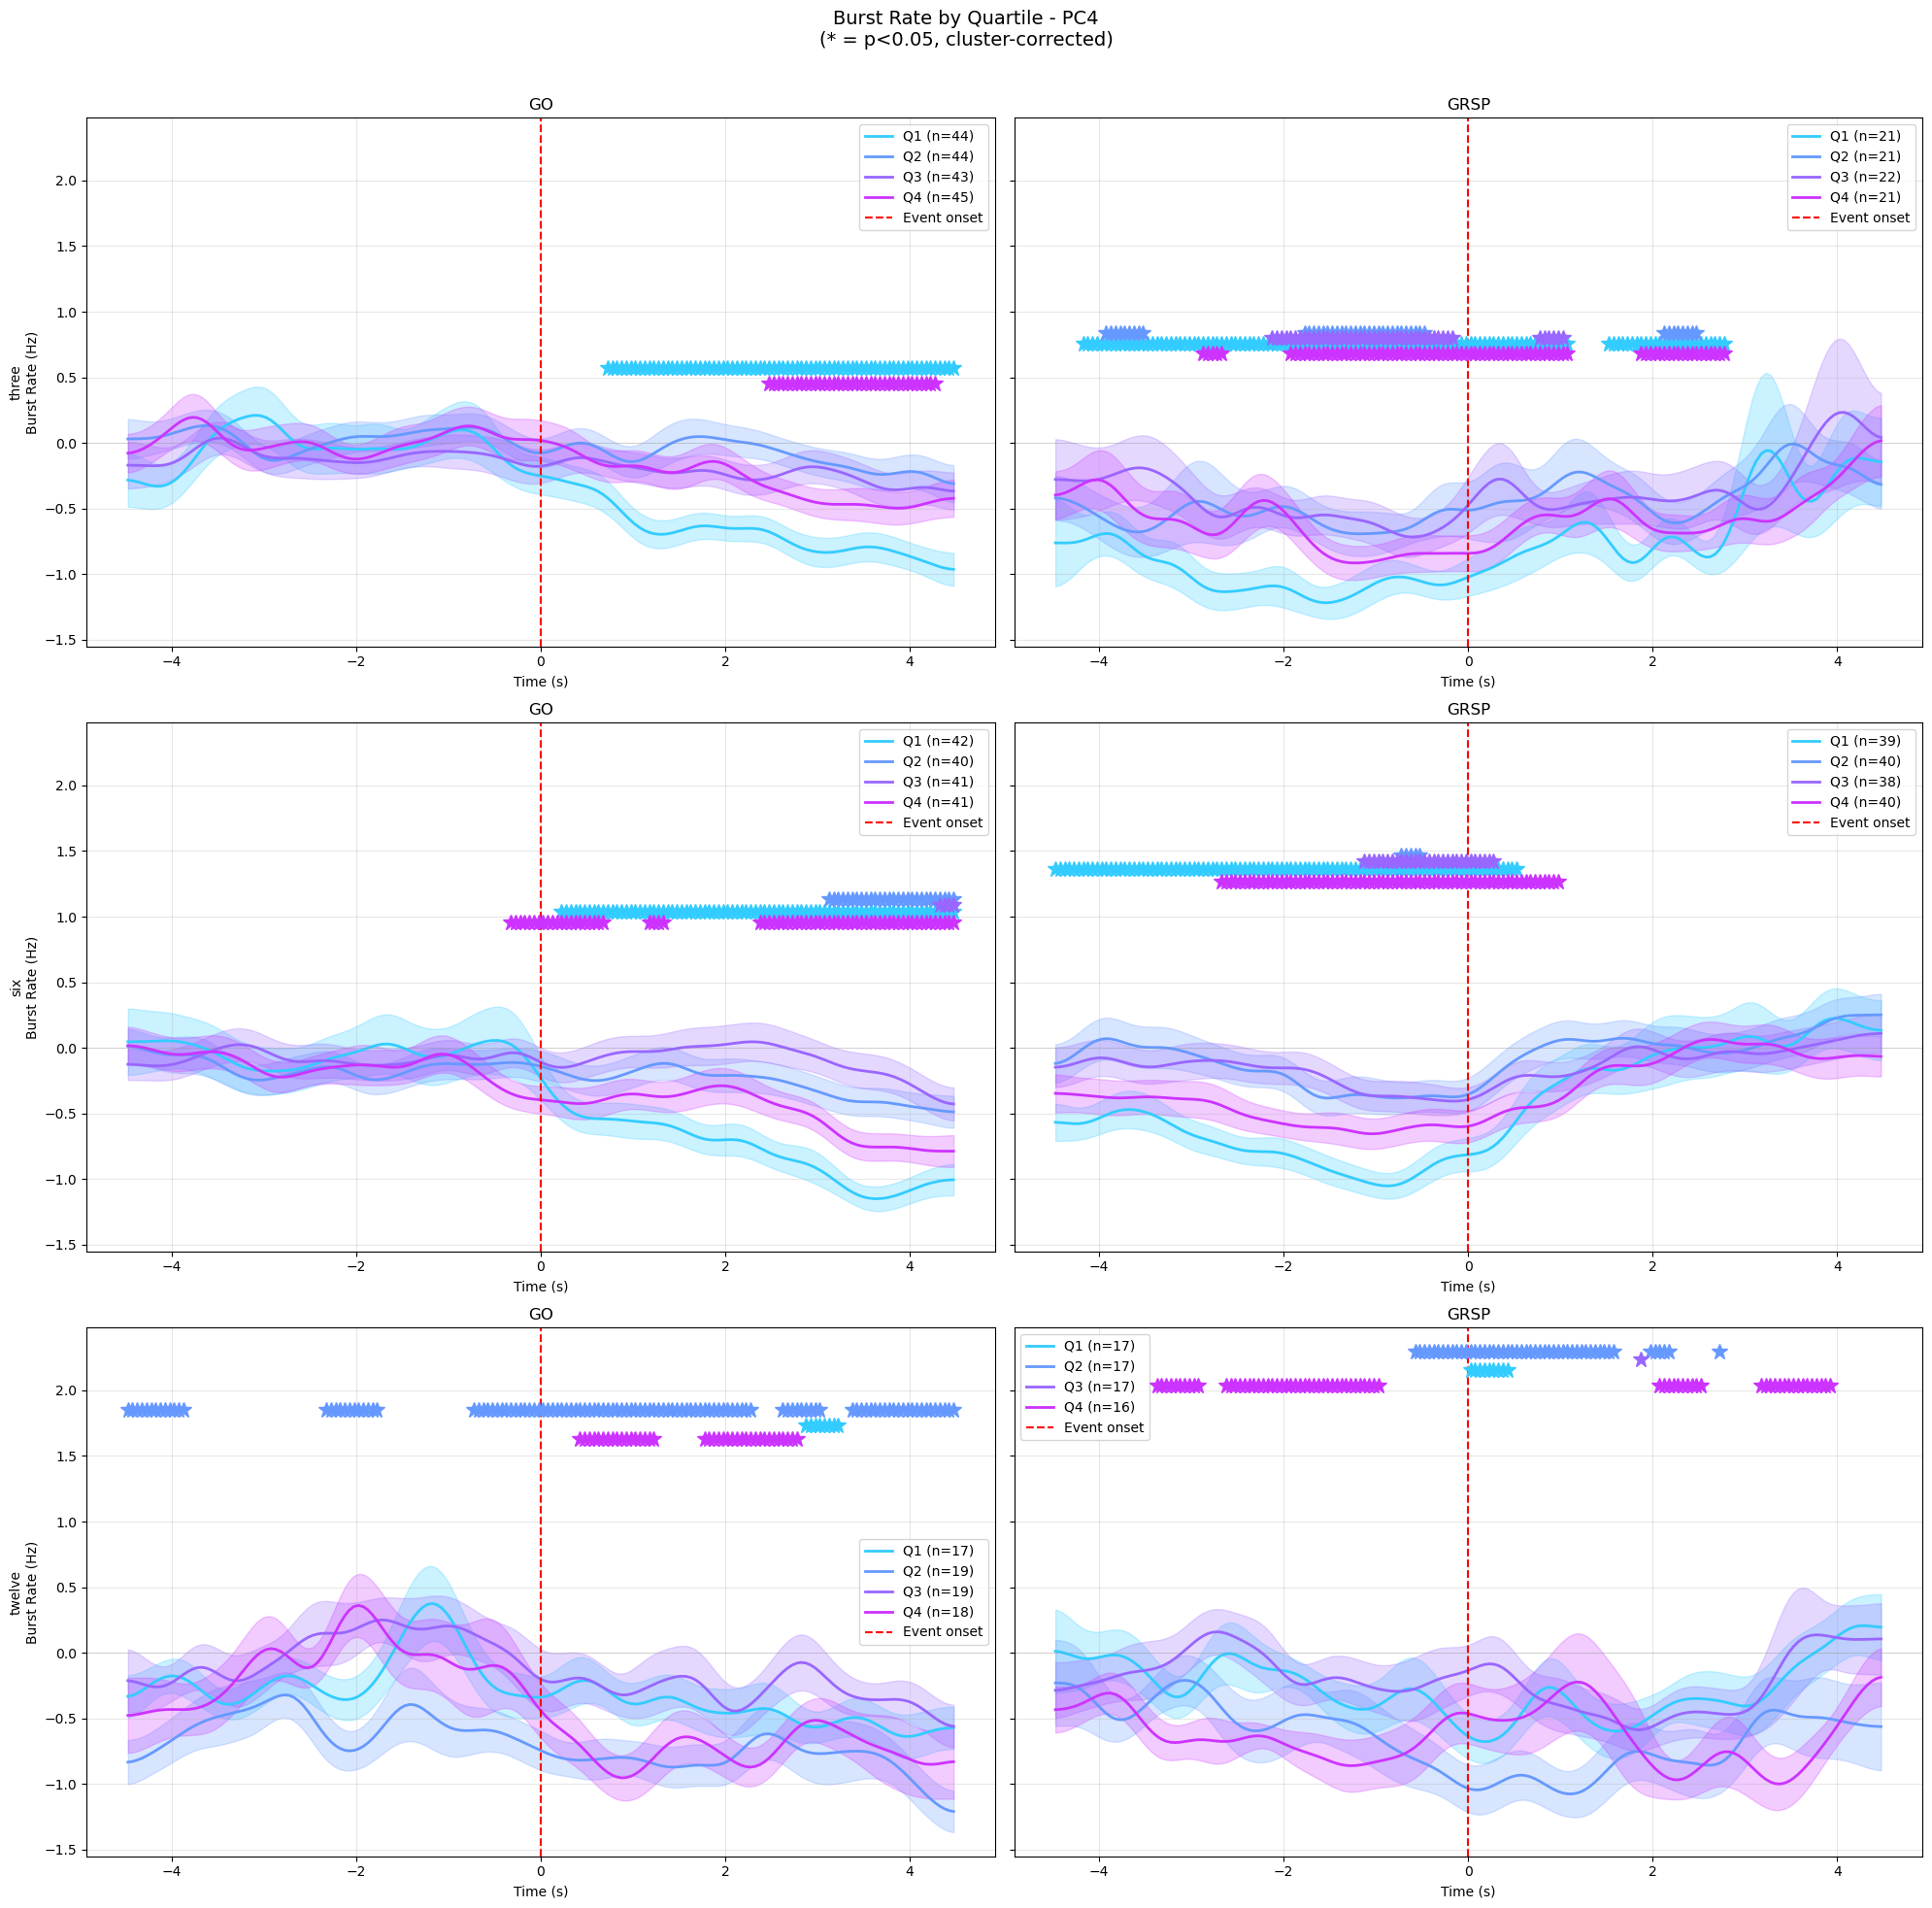

 PC5

three - go:
 [1.12, 1.42]s, center 1.27s
 [2.52, 4.47]s, center 3.52s
 [0.77, 1.82]s, center 1.32s
 [1.97, 4.47]s, center 3.22s

three - grsp:
 [-4.47, -4.08]s, center -4.28s
 [-3.58, -3.43]s, center -3.48s
 [-2.88, 0.02]s, center -1.43s
 [1.67, 2.57]s, center 2.12s
 [-2.63, -2.43]s, center -2.53s
 [-1.03, -0.38]s, center -0.68s
 [0.07, 0.22]s, center 0.17s
 [0.47, 0.82]s, center 0.67s
 [2.17, 2.32]s, center 2.27s
 [-3.08, -2.68]s, center -2.88s
 [-1.88, -0.03]s, center -0.93s
 [0.72, 1.02]s, center 0.87s
 [-4.47, -4.13]s, center -4.28s
 [-3.98, 2.87]s, center -0.53s

six - go:
 [2.42, 4.47]s, center 3.47s
 [3.67, 4.47]s, center 4.07s
 [3.02, 4.47]s, center 3.77s
 [-0.23, 4.47]s, center 2.12s

six - grsp:
 [-2.93, 0.42]s, center -1.23s
 [-1.78, 0.32]s, center -0.73s
 [-1.63, -0.33]s, center -0.98s
 [-4.47, 0.57]s, center -1.93s

twelve - go:
 [0.67, 1.07]s, center 0.87s
 [1.72, 2.27]s, center 2.02s
 [-4.47, -4.08]s, center -4.28s
 [-3.43, -3.38]s, center -3.38s
 [-2.43, -1.68]s, 

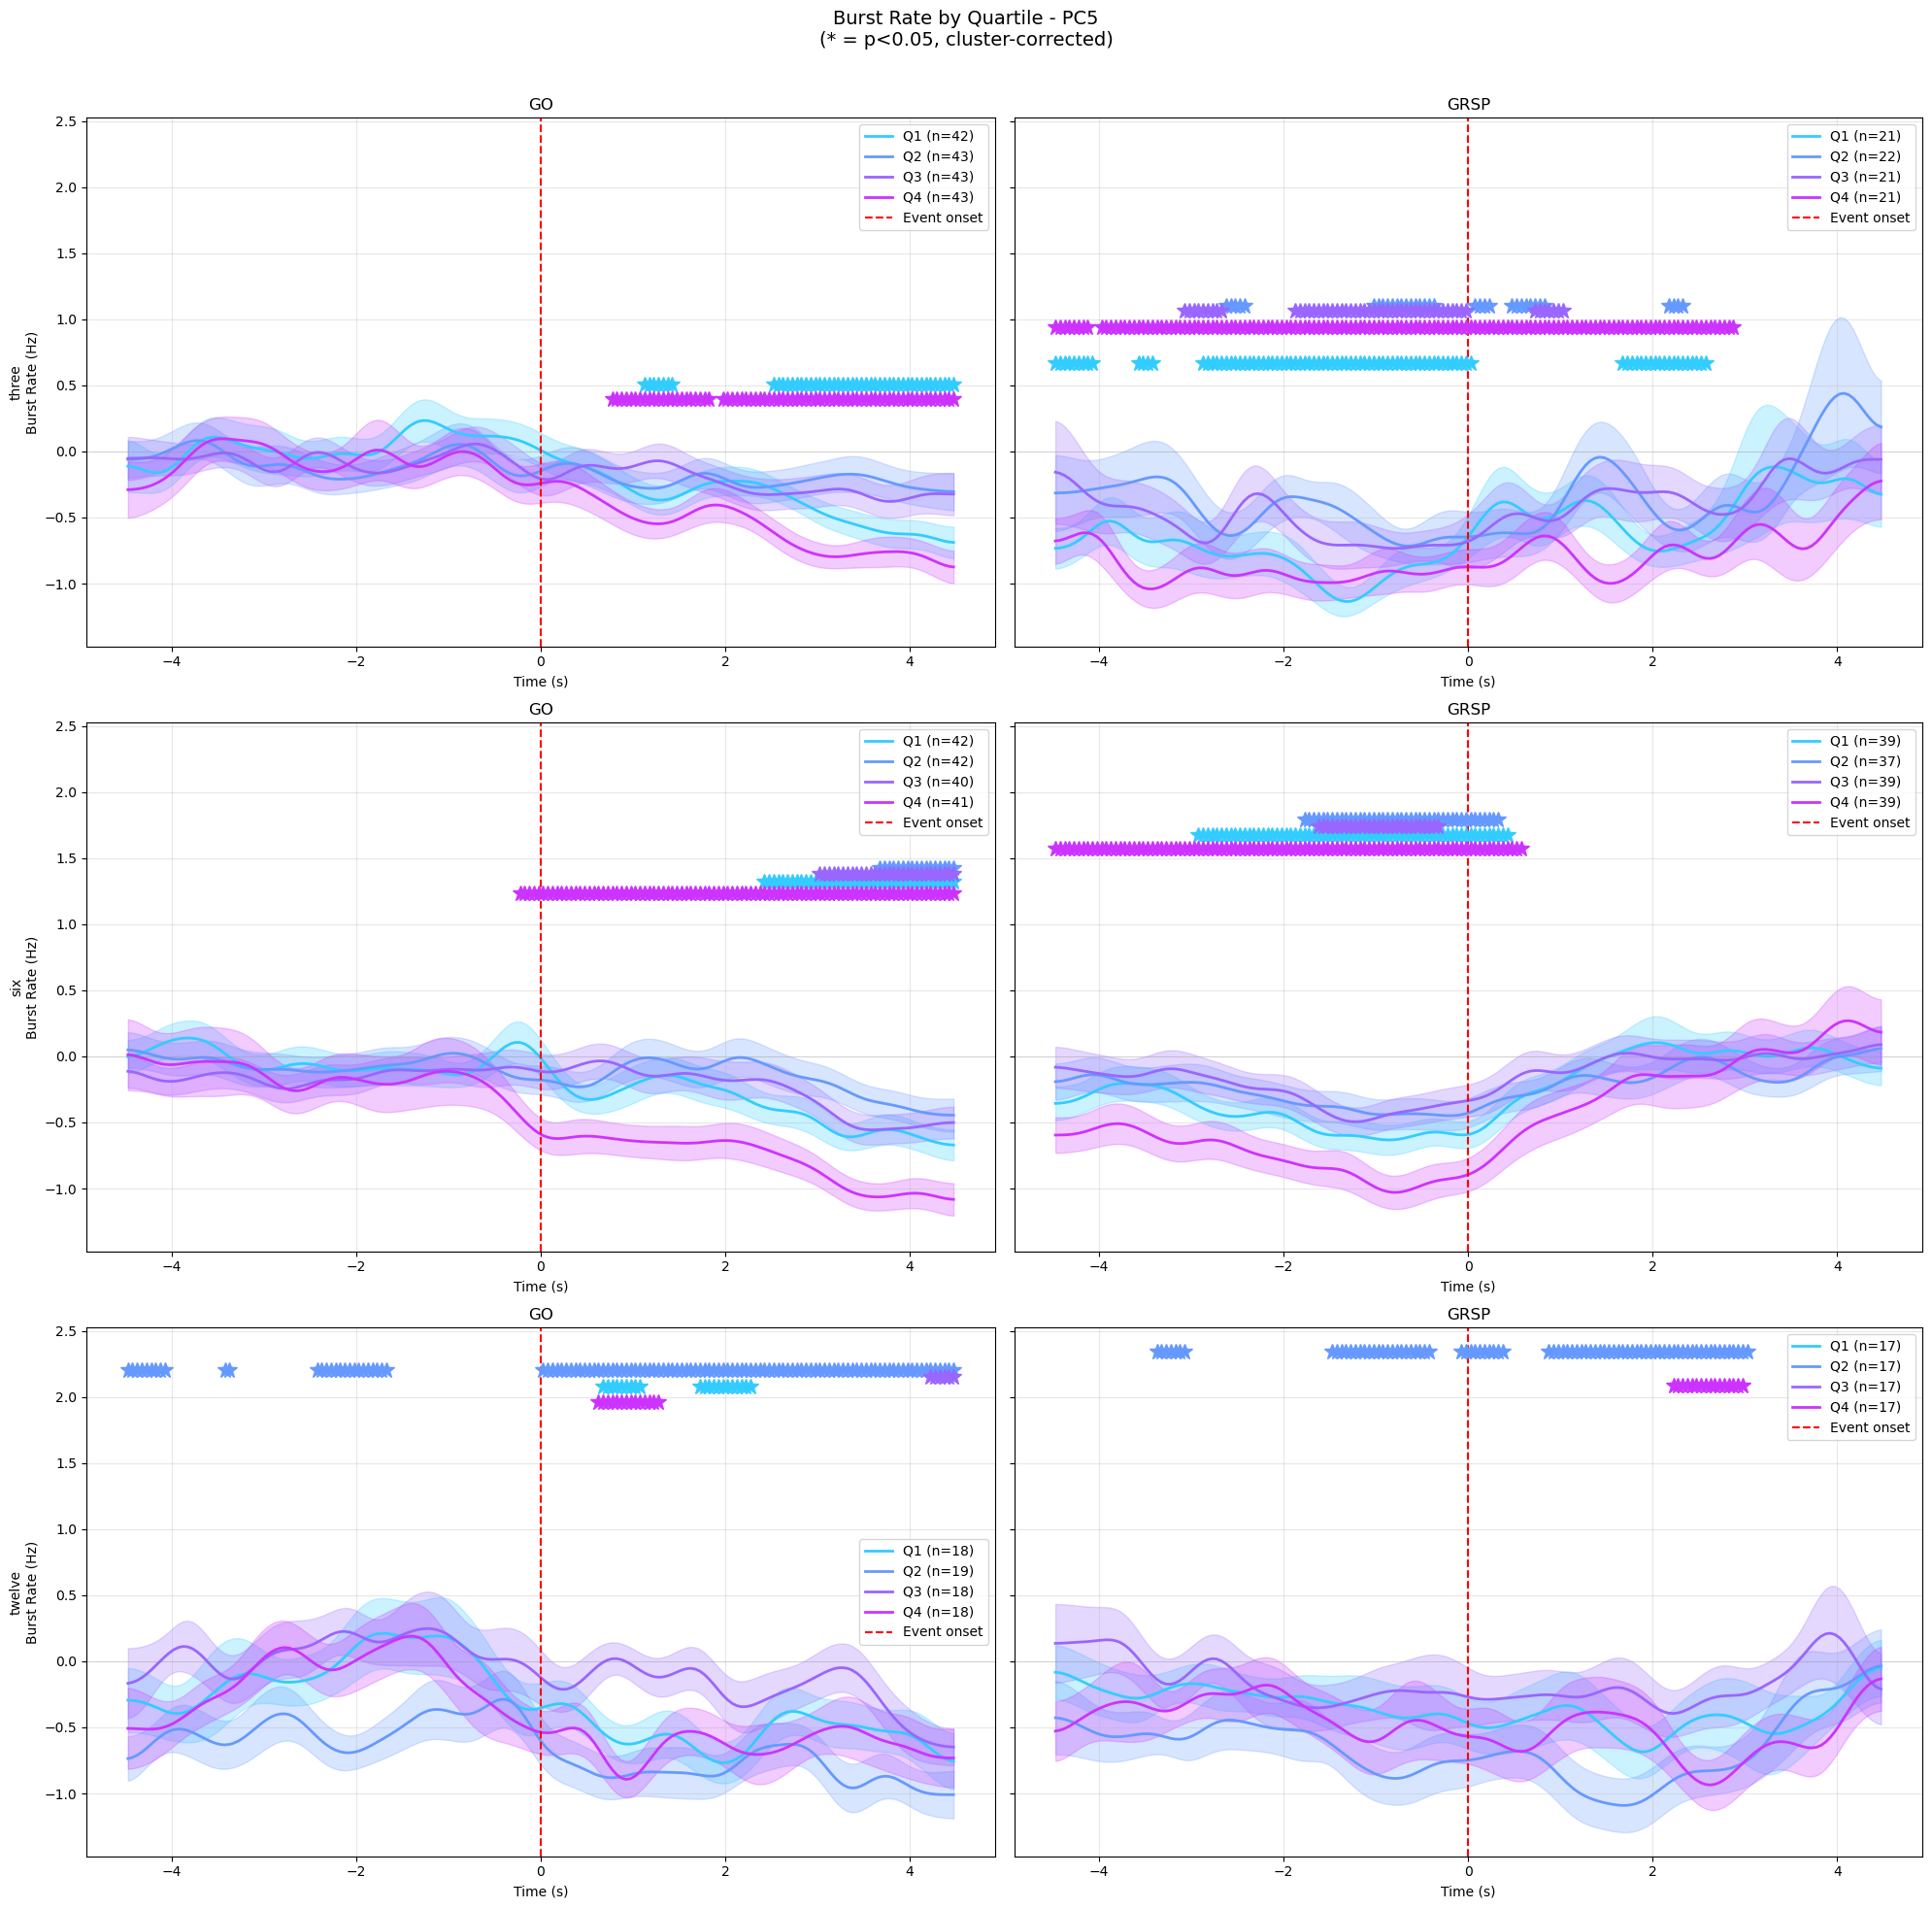

 PC6

three - go:
 [0.82, 4.47]s, center 2.67s
 [0.82, 1.22]s, center 1.02s
 [2.07, 4.47]s, center 3.27s

three - grsp:
 [-4.47, 3.02]s, center -0.73s
 [-4.38, -4.23]s, center -4.28s
 [-3.73, -3.23]s, center -3.48s
 [-2.98, -2.43]s, center -2.68s
 [-2.18, 0.07]s, center -1.03s
 [0.87, 1.02]s, center 0.97s
 [1.52, 2.02]s, center 1.77s
 [3.82, 4.47]s, center 4.17s
 [-2.68, -2.43]s, center -2.53s
 [-0.98, 0.92]s, center -0.03s
 [-2.73, -0.13]s, center -1.43s
 [2.02, 2.72]s, center 2.37s

six - go:
 [2.42, 4.47]s, center 3.47s
 [3.22, 4.47]s, center 3.87s
 [3.97, 4.47]s, center 4.22s
 [-0.08, 4.47]s, center 2.22s

six - grsp:
 [-2.73, 0.47]s, center -1.13s
 [-1.83, 0.37]s, center -0.73s
 [-1.73, -1.13]s, center -1.43s
 [-4.47, -3.93]s, center -4.18s
 [-3.08, 0.47]s, center -1.28s
 [0.77, 1.17]s, center 0.97s

twelve - go:
 [0.72, 1.22]s, center 0.97s
 [1.97, 2.42]s, center 2.22s
 [2.72, 3.32]s, center 3.02s
 [4.17, 4.47]s, center 4.32s
 [3.77, 4.17]s, center 3.97s
 [-4.47, -3.93]s, center 

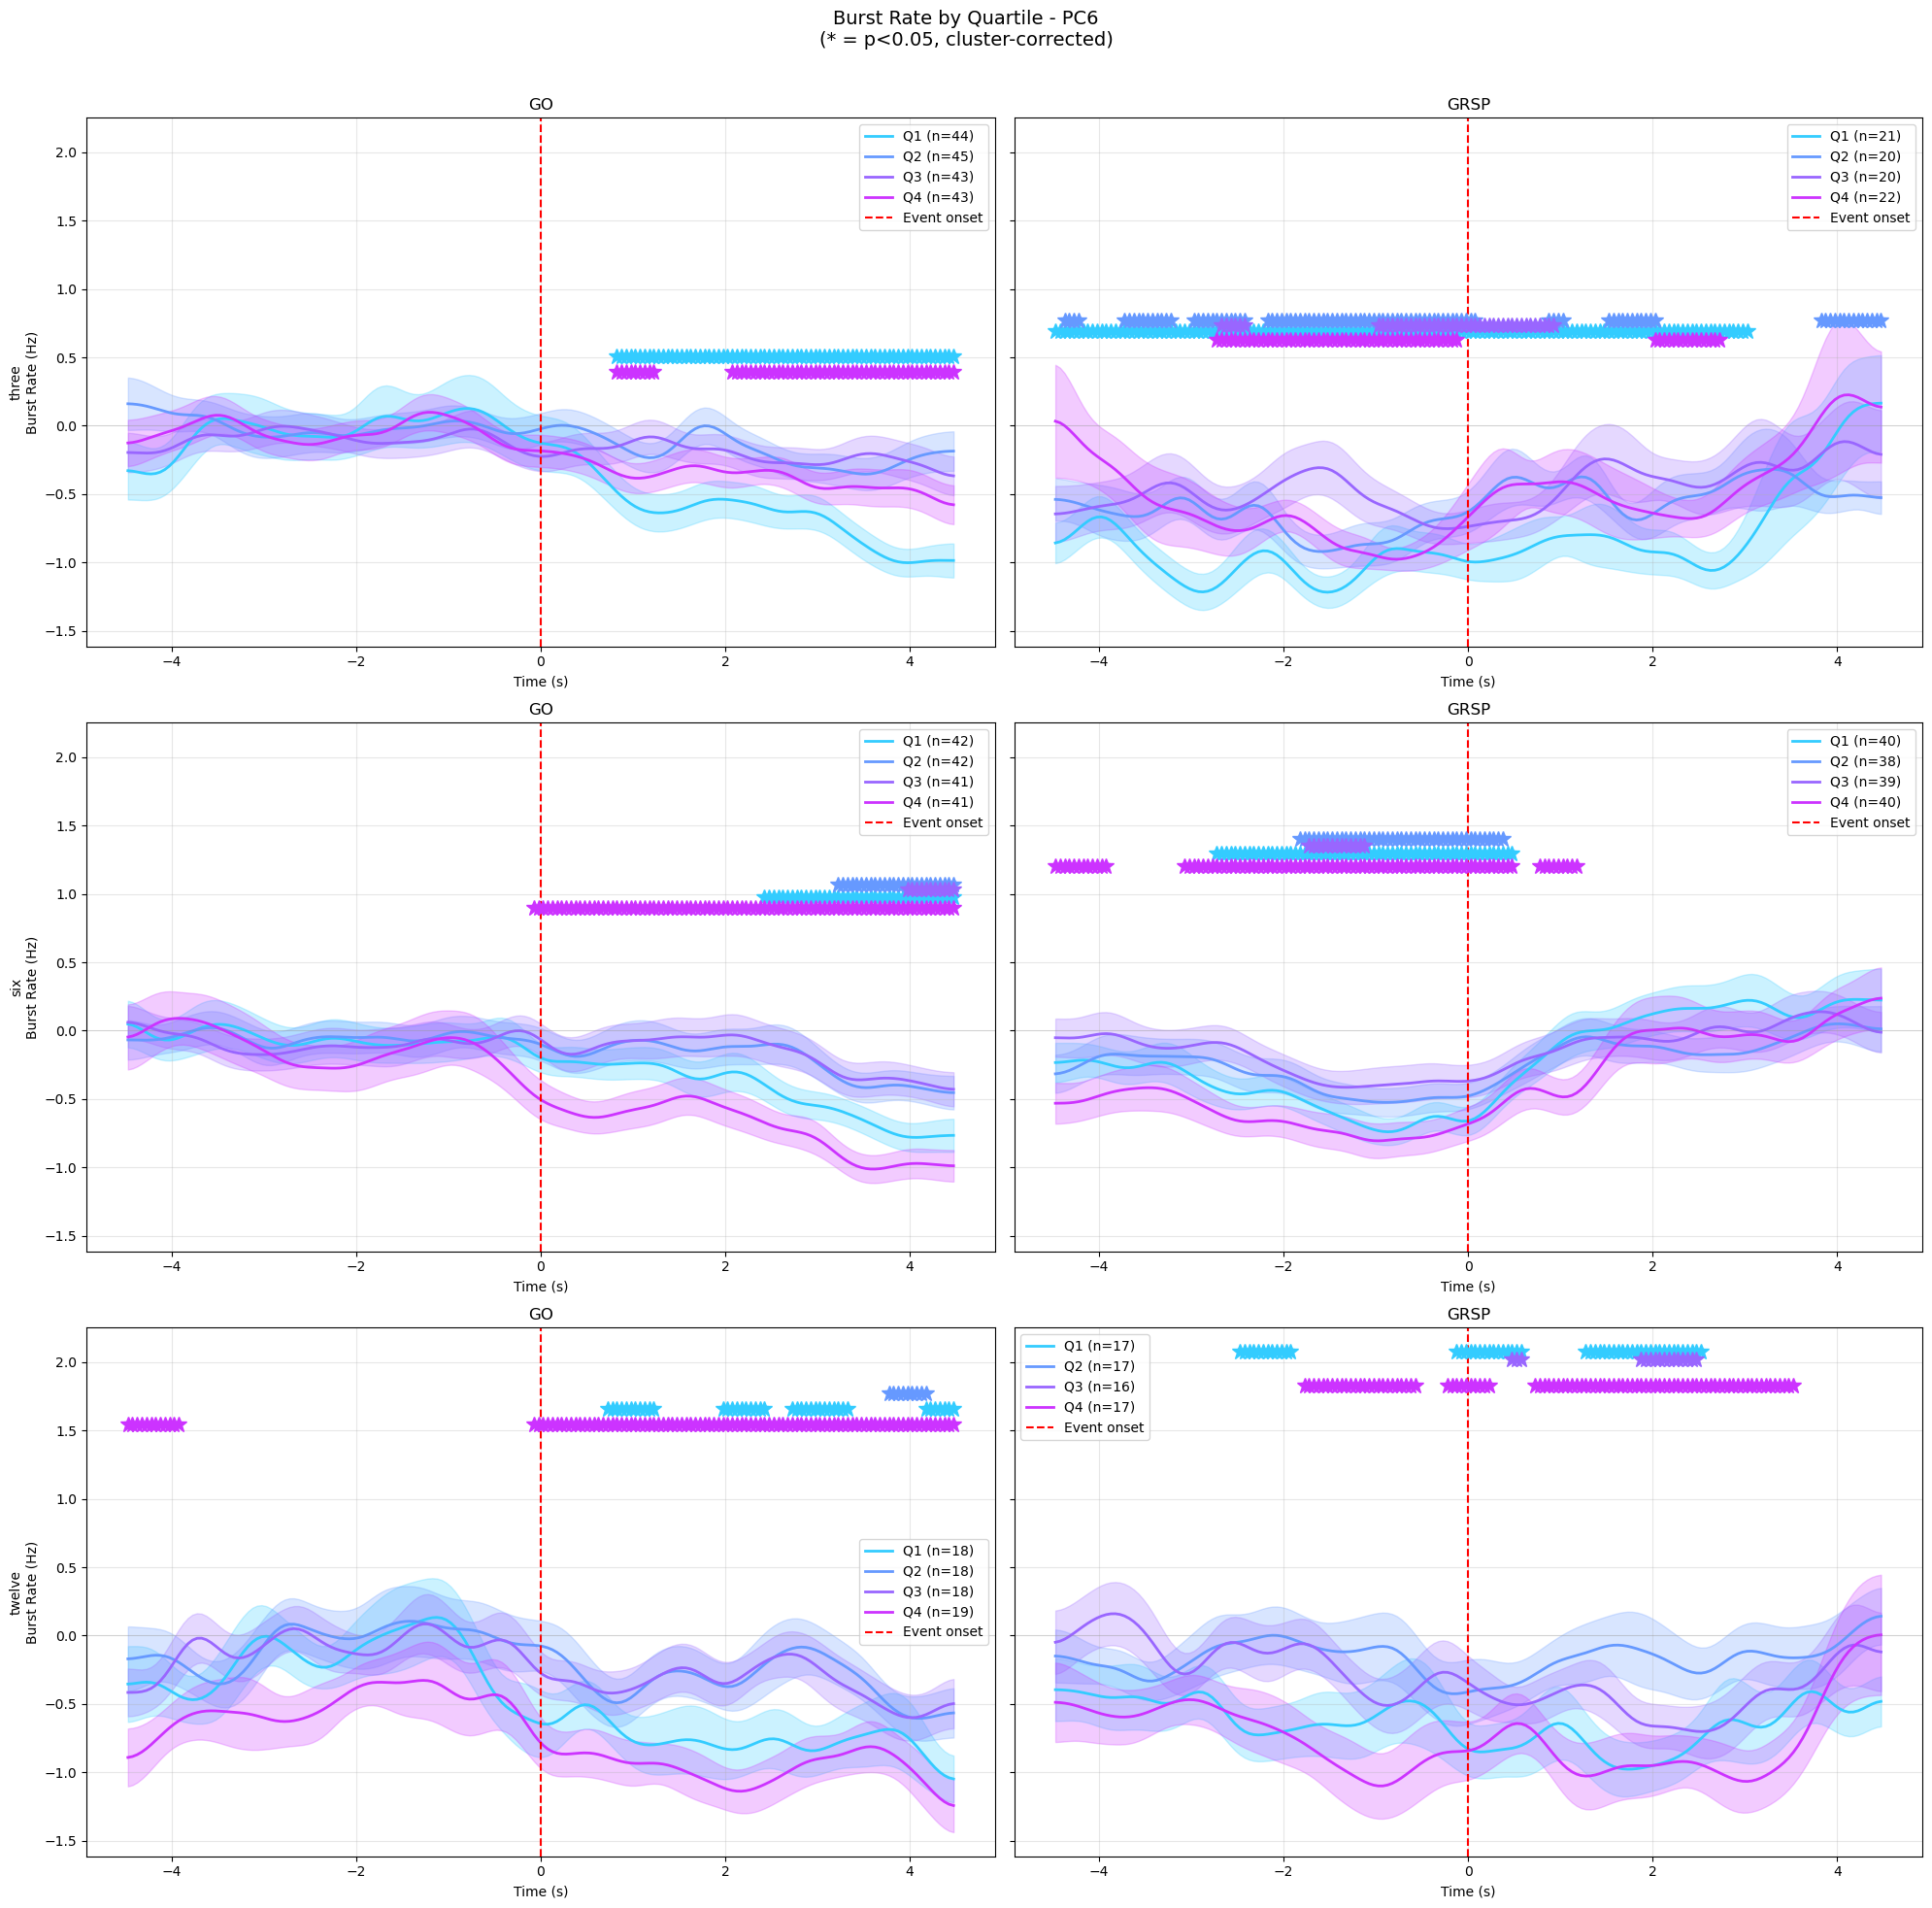

 PC7

three - go:
 [1.07, 4.47]s, center 2.77s
 [0.67, 1.37]s, center 1.02s
 [2.02, 4.47]s, center 3.27s

three - grsp:
 [-4.47, 0.42]s, center -2.03s
 [0.87, 1.07]s, center 0.97s
 [1.67, 2.87]s, center 2.27s
 [-4.28, -4.13]s, center -4.18s
 [-2.98, -2.48]s, center -2.73s
 [-1.93, -0.28]s, center -1.08s
 [2.77, 2.82]s, center 2.82s
 [4.37, 4.47]s, center 4.42s
 [-1.58, -0.13]s, center -0.83s
 [-4.47, -4.38]s, center -4.42s
 [-3.48, -2.63]s, center -3.03s
 [-2.03, 0.02]s, center -0.98s
 [0.72, 2.37]s, center 1.57s

six - go:
 [2.72, 4.47]s, center 3.62s
 [3.22, 3.77]s, center 3.52s
 [3.97, 4.47]s, center 4.22s
 [3.07, 4.47]s, center 3.77s
 [-0.08, 4.47]s, center 2.22s

six - grsp:
 [-4.47, -4.33]s, center -4.38s
 [-2.58, -2.33]s, center -2.43s
 [-1.73, 0.07]s, center -0.83s
 [-1.43, -0.68]s, center -1.03s
 [-0.13, 0.07]s, center -0.03s
 [-1.43, -0.73]s, center -1.08s
 [-0.23, 0.12]s, center -0.03s
 [-4.13, 0.92]s, center -1.58s

twelve - go:
 [0.52, 1.47]s, center 1.02s
 [1.57, 2.87]s, 

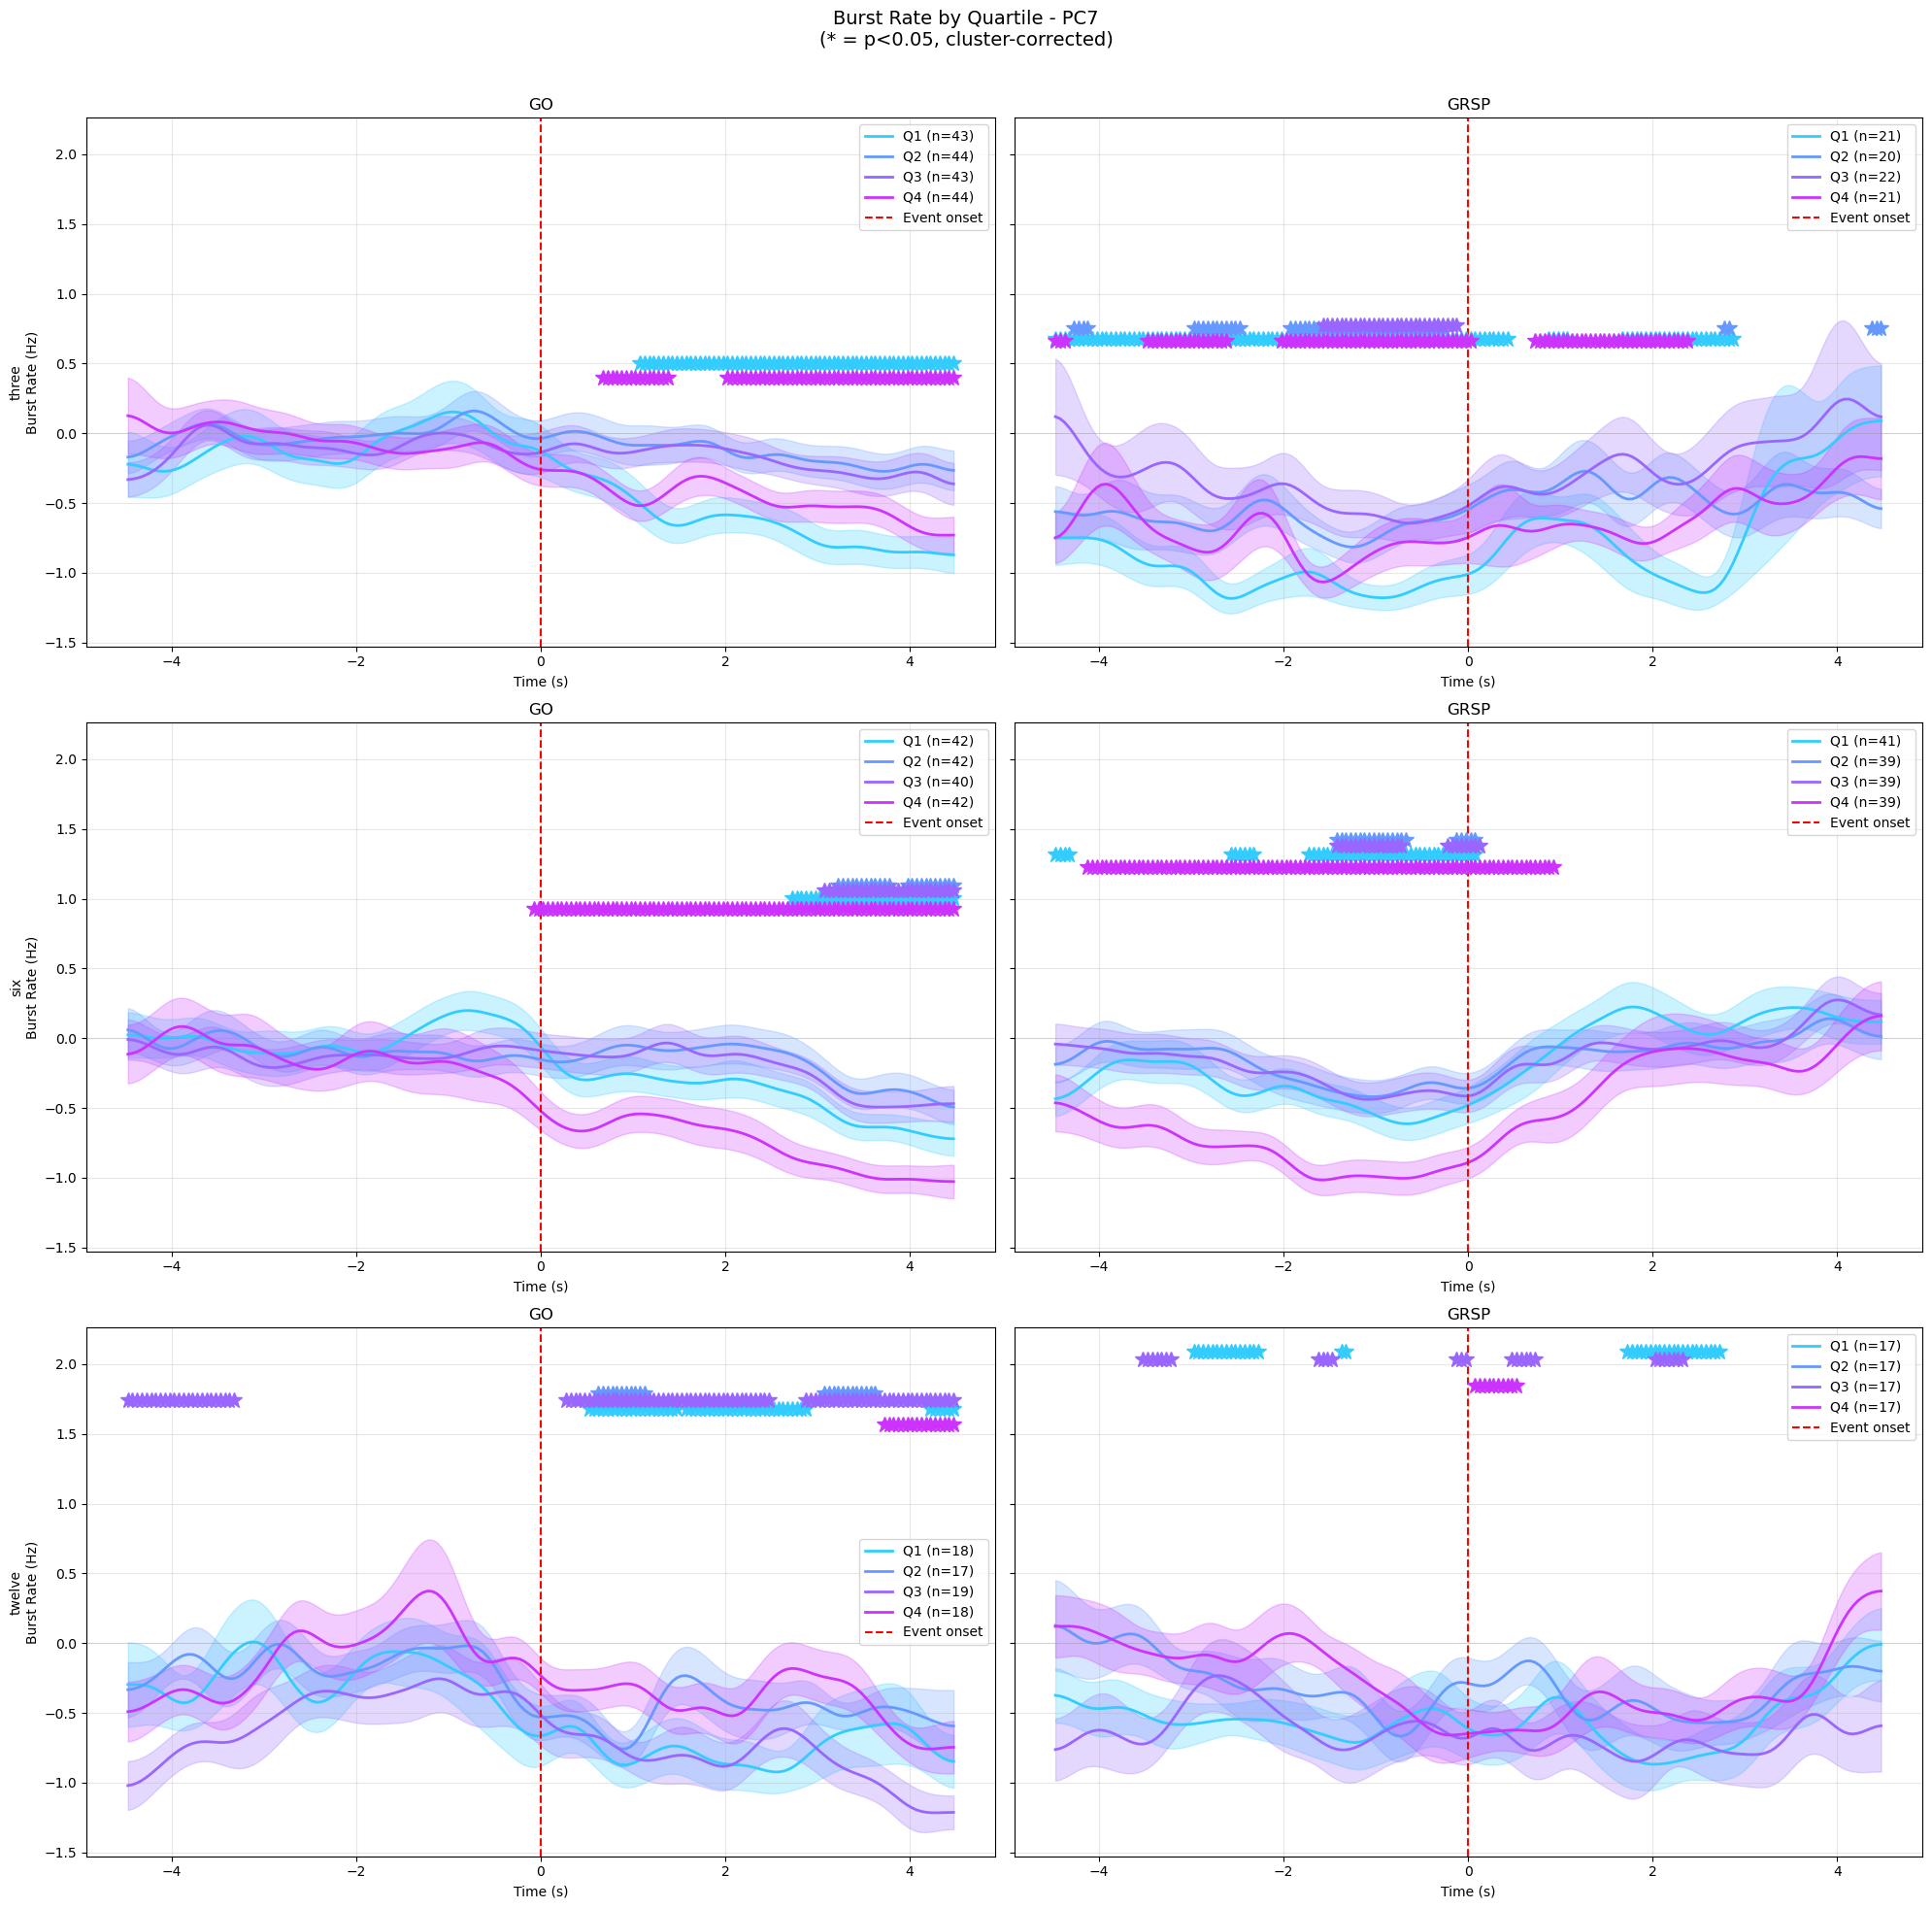

 PC8

three - go:
 [1.07, 4.47]s, center 2.77s
 [1.92, 4.47]s, center 3.22s

three - grsp:
 [-4.47, -4.13]s, center -4.28s
 [-3.68, 0.67]s, center -1.48s
 [1.42, 2.77]s, center 2.12s
 [-3.98, -3.63]s, center -3.78s
 [-1.93, 0.32]s, center -0.78s
 [-2.33, -2.28]s, center -2.28s
 [-1.93, -1.58]s, center -1.73s
 [-0.93, -0.38]s, center -0.63s
 [0.72, 0.97]s, center 0.87s
 [-4.03, 0.02]s, center -1.98s
 [0.72, 1.22]s, center 0.97s
 [1.67, 3.17]s, center 2.42s

six - go:
 [-0.08, 0.62]s, center 0.27s
 [0.97, 4.47]s, center 2.72s
 [3.27, 4.47]s, center 3.87s
 [3.22, 3.57]s, center 3.42s
 [3.72, 4.47]s, center 4.12s
 [0.37, 0.82]s, center 0.62s
 [1.42, 4.47]s, center 2.97s

six - grsp:
 [-2.68, 0.47]s, center -1.08s
 [-2.13, -0.68]s, center -1.38s
 [-0.18, 0.17]s, center 0.02s
 [-1.53, 0.17]s, center -0.68s
 [-4.47, 1.07]s, center -1.68s

twelve - go:
 [0.87, 1.22]s, center 1.07s
 [1.82, 2.22]s, center 2.02s
 [2.72, 2.77]s, center 2.77s
 [-4.08, -3.88]s, center -3.98s
 [-0.23, 4.47]s, center 

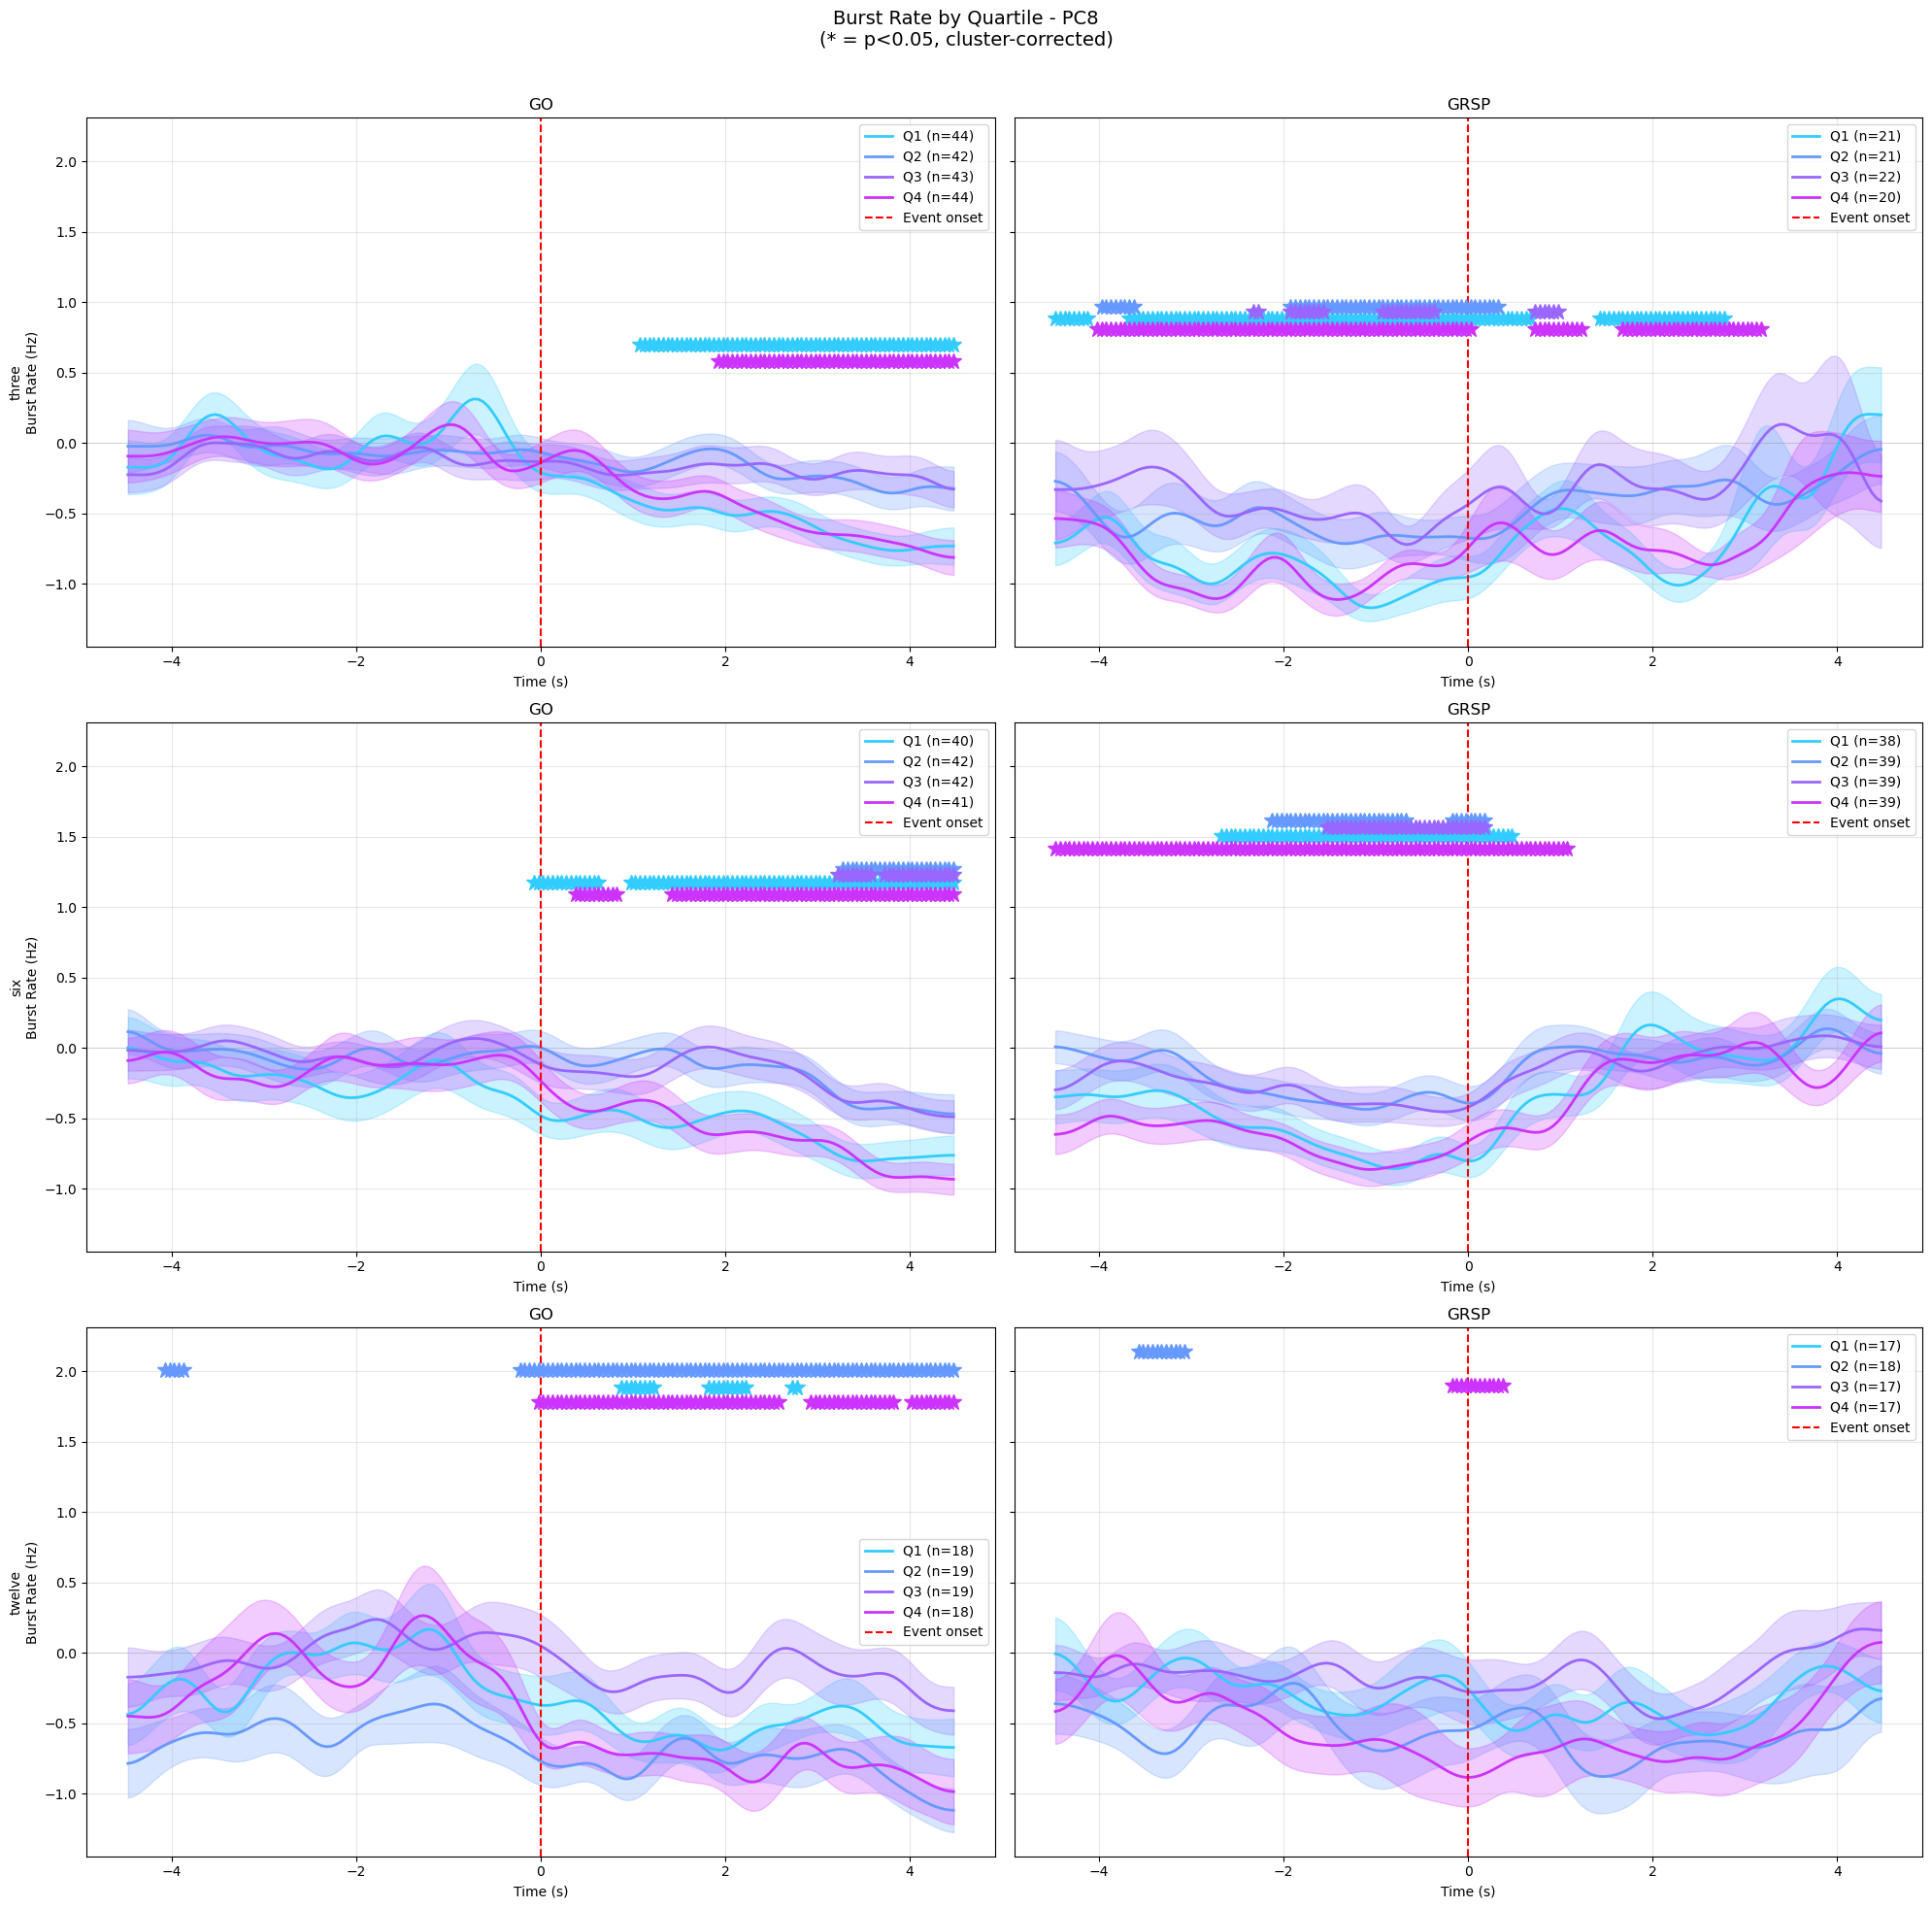

 PC10

three - go:
 [0.27, 0.77]s, center 0.52s
 [0.87, 4.47]s, center 2.67s
 [1.02, 1.57]s, center 1.32s
 [1.97, 4.47]s, center 3.22s

three - grsp:
 [-4.47, 0.57]s, center -1.93s
 [1.37, 3.87]s, center 2.62s
 [-1.18, -0.03]s, center -0.58s
 [0.62, 0.92]s, center 0.77s
 [3.42, 3.57]s, center 3.52s
 [-1.83, -1.63]s, center -1.73s
 [-0.83, -0.03]s, center -0.43s
 [1.82, 2.47]s, center 2.17s
 [-4.38, -4.08]s, center -4.23s
 [-3.48, -3.23]s, center -3.33s
 [-1.88, -0.18]s, center -1.03s
 [1.72, 1.77]s, center 1.77s

six - go:
 [-0.03, 0.32]s, center 0.17s
 [1.57, 2.12]s, center 1.87s
 [2.67, 4.47]s, center 3.57s
 [3.27, 4.47]s, center 3.87s
 [3.02, 4.47]s, center 3.77s
 [0.17, 4.47]s, center 2.32s

six - grsp:
 [-2.53, 0.37]s, center -1.08s
 [-1.33, 0.12]s, center -0.58s
 [-1.48, -0.83]s, center -1.13s
 [-4.47, 0.97]s, center -1.73s

twelve - go:
 [0.02, 0.17]s, center 0.12s
 [0.52, 1.22]s, center 0.87s
 [3.47, 4.47]s, center 3.97s
 [-4.47, -3.23]s, center -3.83s
 [0.12, 4.47]s, center 2.

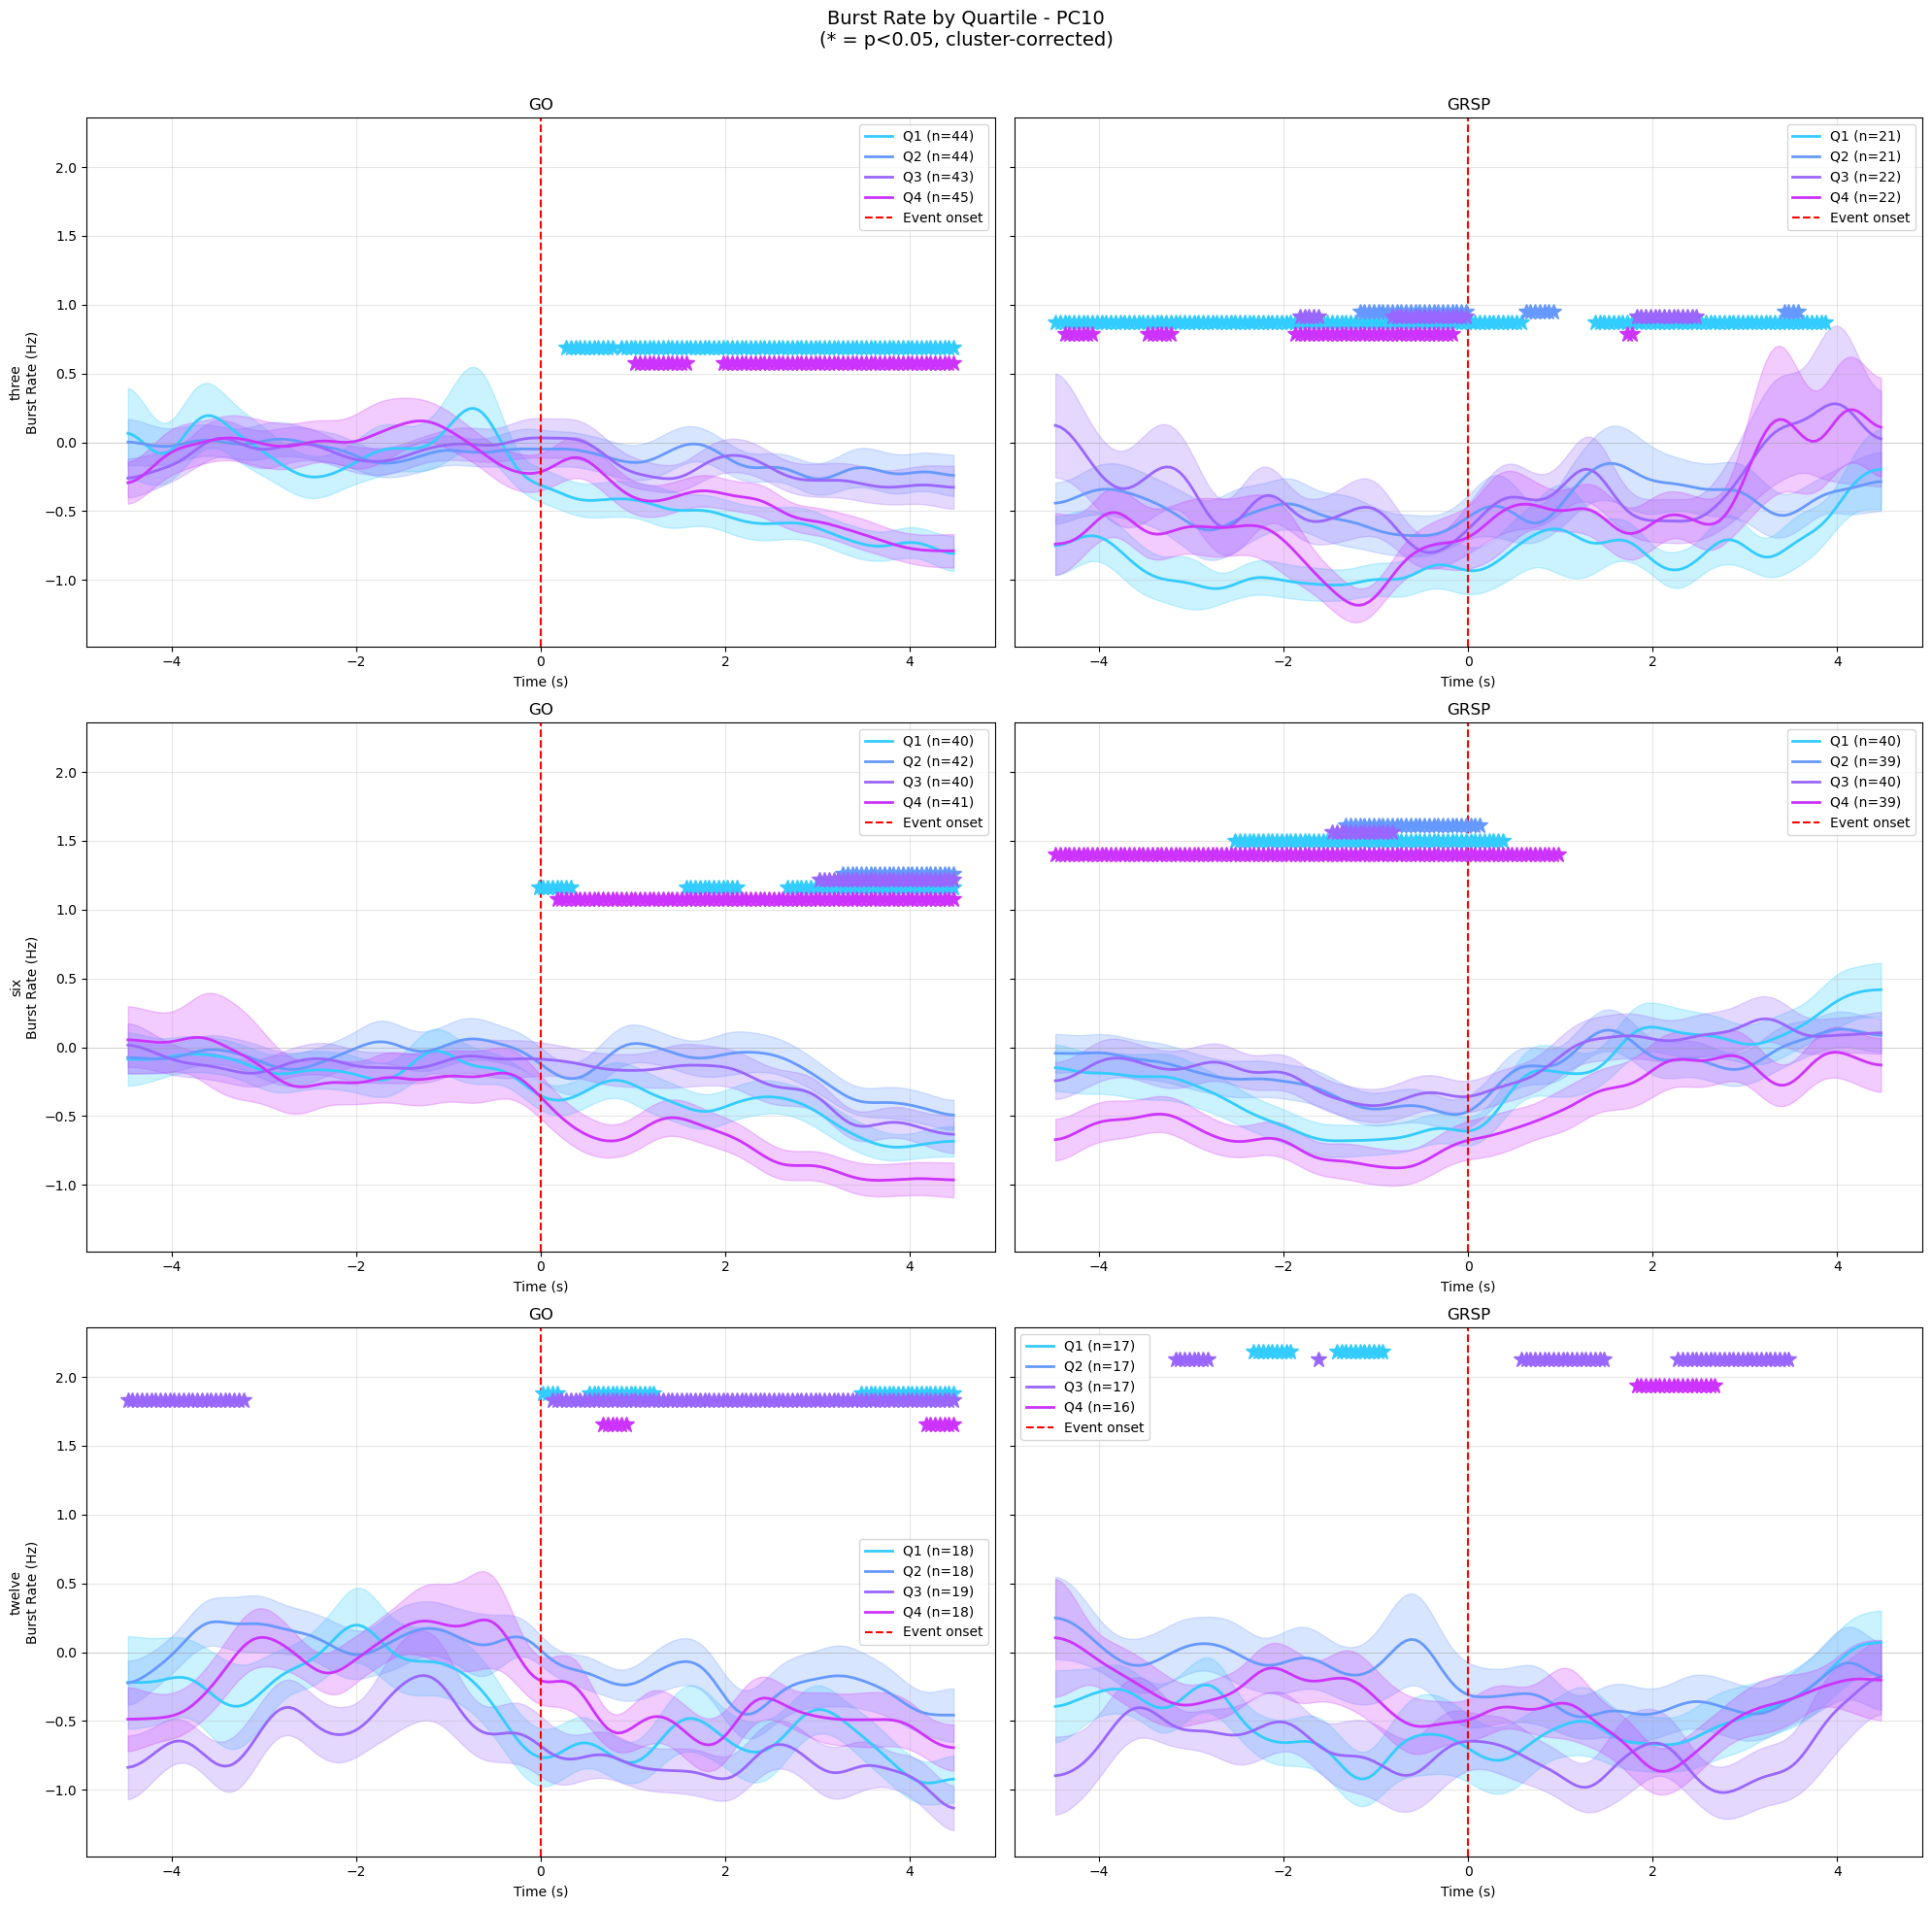

In [96]:
age_list = ['three', 'six', 'twelve']
pcs = ['PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC10']
epochs = ['go', 'grsp']
quartile_colors = plt.cm.cool(np.linspace(0.2, 0.8, 4))

for pc in pcs:

    fig, axes = plt.subplots(len(age_list), len(epochs), figsize=(20, 20), sharey=True)
    
    print(f" {pc}")

    for i, age in enumerate(age_list):
        for j, epoch_type in enumerate(epochs):
            ax = axes[i, j] if len(age_list) > 1 else axes[j]
            
            print(f"\n{age} - {epoch_type}:")

            bin_centers, q_rates, excluded = compute_quartile_burst_rates(
                df_all, pc_name=pc, age=age, epoch=epoch_type, 
                exclude_outliers=True,
                outlier_threshold=2.0
            )
            
            if bin_centers is None:
                continue
            
             # For each quartile: plot and calculate significance
            for q_idx, (q, color) in enumerate(zip([1, 2, 3, 4], quartile_colors)):
                rates = q_rates[f'Q{q}']
                #for subj_rate in q_rates[f'Q{q}']:
                        #ax.plot(bin_centers, subj_rate, color=color, alpha=0.25, linewidth=1)
                if len(rates) == 0:
                    continue
                
                # Calcul des statistiques
                mean_rate = np.mean(rates, axis=0)
                se_rate = np.std(rates, axis=0) / np.sqrt(rates.shape[0])
                
                # Plot de la courbe moyenne
                ax.plot(bin_centers, mean_rate, color=color, linewidth=2, 
                       label=f'Q{q} (n={len(rates)})')
                ax.fill_between(bin_centers, mean_rate - se_rate, mean_rate + se_rate,
                               color=color, alpha=0.25)
                
                # CALCUL DE LA SIGNIFICATIVITÉ
                sig_mask, clusters, p_values = compute_significance_clusters(
                    rates, 
                    n_comps=len(pcs), 
                    n_quartiles=4,
                    alpha=0.05,
                    n_permutations=1000
                )
                
                # Afficher les étoiles pour les périodes significatives
                if np.any(sig_mask):
                    y_min, y_max = ax.get_ylim()
                    top_offset = 0.04  # % au-dessus du max
                    step = 0.05        # % entre chaque quartile
                    y_pos = y_max + top_offset * (y_max - y_min) - q_idx * step * (y_max - y_min)
                    
                    # Trouver les régions continues significatives
                    sig_regions = np.where(np.diff(np.concatenate(([False], sig_mask, [False]))))[0].reshape(-1, 2)
                    
                    for start, end in sig_regions:
                        center_idx = (start + end) // 2
                        print(f" [{bin_centers[start]:.2f}, {bin_centers[end-1]:.2f}]s, center {bin_centers[center_idx]:.2f}s")
                        for t in range(start,end):
                            ax.plot(bin_centers[t], y_pos, '*', 
                                   color=color, markersize=12, markeredgecolor=color, 
                                   markeredgewidth=1.0, zorder=10)
            
            ax.axvline(0, color='red', linestyle='--', label='Event onset')
            ax.axhline(0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
            ax.set_title(f"{epoch_type.upper()}")
            ax.set_xlabel('Time (s)')
            if j == 0:
                ax.set_ylabel(f'{age}\nBurst Rate (Hz)')
            ax.grid(True, alpha=0.3)
            ax.legend()

    fig.suptitle(f'Burst Rate by Quartile - {pc}\n(* = p<0.05, cluster-corrected)', 
                fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f'burst_rate_{pc}_with_stats.png', dpi=300, bbox_inches='tight')
    plt.show()